In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier






In [7]:
#step 1: Loading the data and inspection

# loading the dataset
file_path = r"C:\Users\alanm\Downloads\Taxi-cancellation-case.csv"  
taxi_data = pd.read_csv (file_path)


#inspecting the first 5 rows
print(taxi_data.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(taxi_data.info())


print("\nSummary Statistics:")
print(taxi_data.describe())

   row#  user_id  vehicle_model_id  package_id  travel_type_id  from_area_id  \
0     1    17712                12         NaN               2        1021.0   
1     2    17037                12         NaN               2         455.0   
2     3      761                12         NaN               2         814.0   
3     4      868                12         NaN               2         297.0   
4     5    21716                28         NaN               2        1237.0   

   to_area_id  from_city_id  to_city_id  from_date  to_date  online_booking  \
0      1323.0           NaN         NaN   41275.94      NaN               0   
1      1330.0           NaN         NaN   41275.53      NaN               0   
2       393.0           NaN         NaN   41276.02  41277.0               1   
3       212.0           NaN         NaN   41275.55      NaN               0   
4       330.0           NaN         NaN   41275.69      NaN               0   

   mobile_site_booking  booking_created   fr

C:\Users\alanm\AppData\Local\Temp\ipykernel_30908\2234246414.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Car_Cancellation", data=taxi_data, palette="coolwarm")


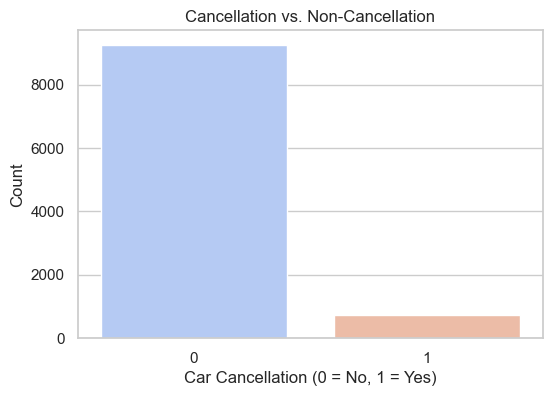

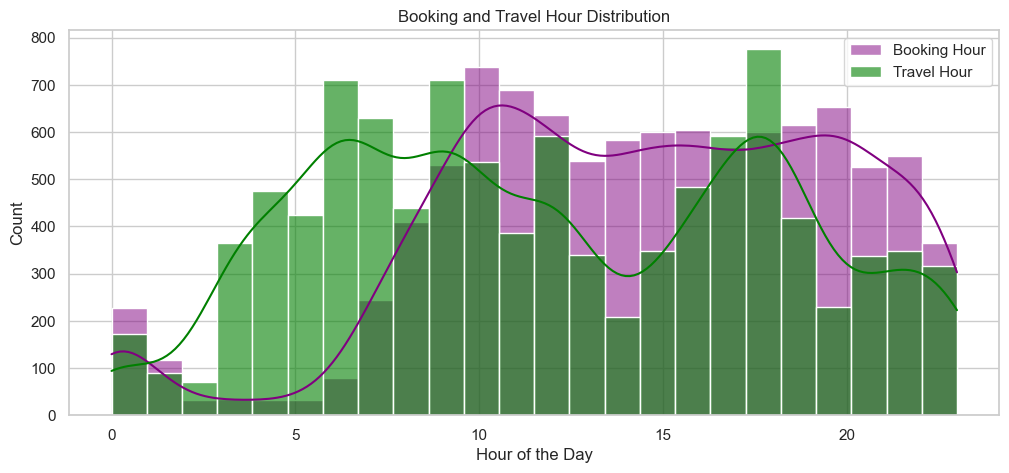

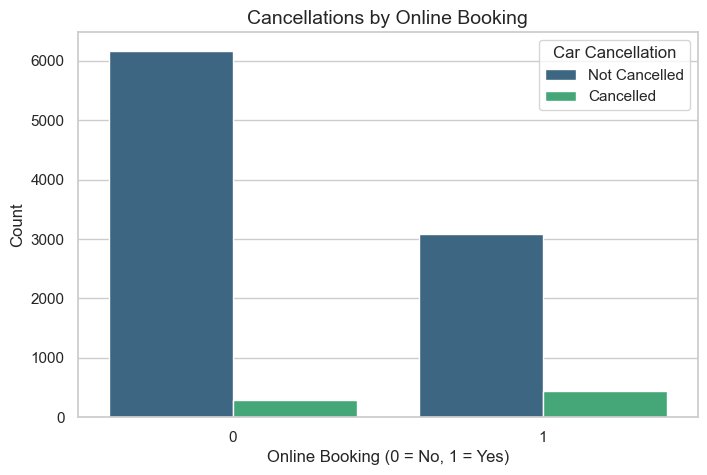

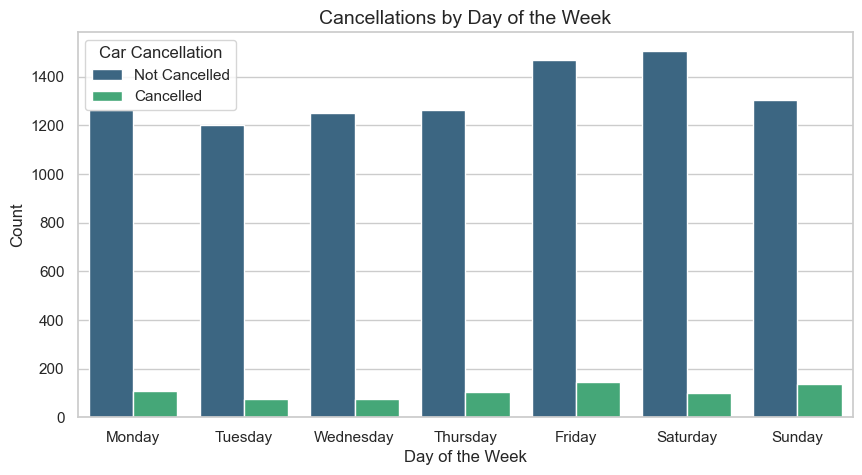

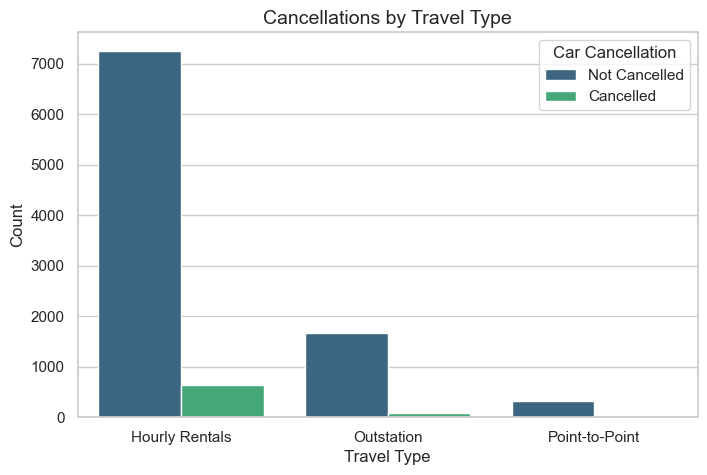

C:\Users\alanm\AppData\Local\Temp\ipykernel_30908\2234246414.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=from_area_counts.index, y=from_area_counts.values, palette="Oranges_r")
C:\Users\alanm\AppData\Local\Temp\ipykernel_30908\2234246414.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=to_area_counts.index, y=to_area_counts.values, palette="Reds_r")


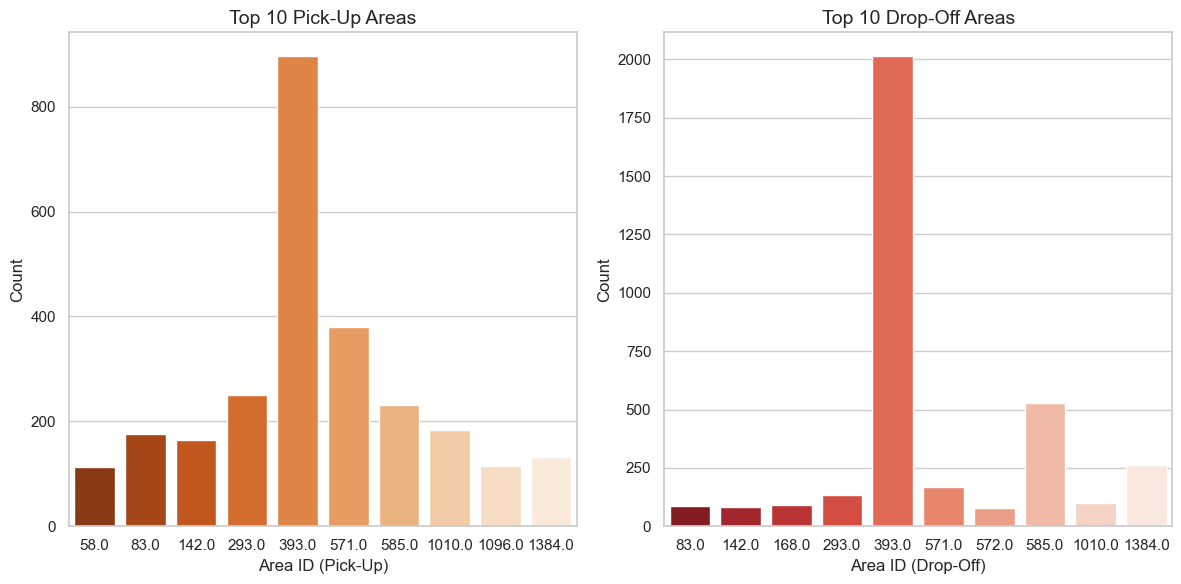

In [8]:
#step 2: Exploratory Data Analysis


# Set Seaborn style
sns.set(style="whitegrid")


### 1 Cancellation Rate Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x="Car_Cancellation", data=taxi_data, palette="coolwarm")
plt.title("Cancellation vs. Non-Cancellation")
plt.xlabel("Car Cancellation (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


### 2️ Booking & Travel Hour Analysis
# Convert booking_created and from_date to datetime format
taxi_data["booking_created"] = pd.to_datetime(taxi_data["booking_created"], unit='D', origin='1899-12-30')
taxi_data["from_date"] = pd.to_datetime(taxi_data["from_date"], unit='D', origin='1899-12-30')

# Extract booking & travel hours
taxi_data["booking_hour"] = taxi_data["booking_created"].dt.hour
taxi_data["travel_hour"] = taxi_data["from_date"].dt.hour

plt.figure(figsize=(12, 5))
sns.histplot(taxi_data["booking_hour"], bins=24, kde=True, color="purple", label="Booking Hour")
sns.histplot(taxi_data["travel_hour"], bins=24, kde=True, color="green", label="Travel Hour", alpha=0.6)
plt.title("Booking and Travel Hour Distribution")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.legend()
plt.show()


### 3 Online bookings vs cancellations
plt.figure(figsize=(8, 5))
sns.countplot(data=taxi_data, x='online_booking', hue='Car_Cancellation', palette="viridis")
plt.title("Cancellations by Online Booking", fontsize=14)
plt.xlabel("Online Booking (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Car Cancellation", labels=["Not Cancelled", "Cancelled"])
plt.show()


### 4 Cancellation by Day
taxi_data['from_day'] = taxi_data['from_date'].dt.day_name()
taxi_data['booking_day'] = taxi_data['booking_created'].dt.day_name()

# Analyze cancellations by day of the week
plt.figure(figsize=(10, 5))
sns.countplot(data=taxi_data, x='from_day', hue='Car_Cancellation', 
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
              palette="viridis")

plt.title("Cancellations by Day of the Week", fontsize=14)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Car Cancellation", labels=["Not Cancelled", "Cancelled"])
plt.show()


### 5 Travel Type vs. Cancellation Rate
# Map travel_type_id to descriptive labels
travel_type_labels = {1: "Point-to-Point", 2: "Hourly Rentals", 3: "Outstation"}
taxi_data["travel_type_desc"] = taxi_data["travel_type_id"].map(travel_type_labels)

# Plot with descriptive labels
plt.figure(figsize=(8, 5))
sns.countplot(data=taxi_data, x='travel_type_desc', hue='Car_Cancellation', palette="viridis")
plt.title("Cancellations by Travel Type", fontsize=14)
plt.xlabel("Travel Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Car Cancellation", labels=["Not Cancelled", "Cancelled"])
plt.show()


### 6 Location-Based Cancellation Trends
# Summarize counts for pick-up and drop-off areas
from_area_counts = taxi_data["from_area_id"].value_counts().head(10)
to_area_counts = taxi_data["to_area_id"].value_counts().head(10)

# Plot side-by-side bar plots for clarity
plt.figure(figsize=(12, 6))

# Plot for From Area
plt.subplot(1, 2, 1)
sns.barplot(x=from_area_counts.index, y=from_area_counts.values, palette="Oranges_r")
plt.title("Top 10 Pick-Up Areas", fontsize=14)
plt.xlabel("Area ID (Pick-Up)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Plot for To Area
plt.subplot(1, 2, 2)
sns.barplot(x=to_area_counts.index, y=to_area_counts.values, palette="Reds_r")
plt.title("Top 10 Drop-Off Areas", fontsize=14)
plt.xlabel("Area ID (Drop-Off)", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()


In [9]:
# Step 3: Data Cleaning

# 1️ Check for missing values
missing_values = taxi_data.isnull().sum() / len(taxi_data) * 100
print("Missing Values (%):\n", missing_values)

# 2️ Drop columns with excessive missing values (>80%)
columns_to_drop = ["package_id", "from_city_id", "to_city_id"]  # Update based on missing value percentage
taxi_data_cleaned = taxi_data.drop(columns=columns_to_drop)
print("\nColumns dropped:", columns_to_drop)

# 3️ Impute missing values for numerical columns
numerical_cols = ["from_area_id", "to_area_id", "from_lat", "from_long", "to_lat", "to_long"]

for col in numerical_cols:
    taxi_data_cleaned[col] = taxi_data_cleaned[col].fillna(taxi_data_cleaned[col].median())

# 4️ Handle missing `to_date` values (assuming they represent one-way trips)
taxi_data_cleaned["to_date"] = taxi_data_cleaned["to_date"].fillna(0)

# 5️ Verify missing values after cleaning
print("\nMissing Values After Cleaning:\n", taxi_data_cleaned.isnull().sum())

# Display dataset info
print(taxi_data_cleaned.info())


Missing Values (%):
 row#                    0.00
user_id                 0.00
vehicle_model_id        0.00
package_id             82.48
travel_type_id          0.00
from_area_id            0.15
to_area_id             20.91
from_city_id           62.94
to_city_id             96.61
from_date               0.00
to_date                41.78
online_booking          0.00
mobile_site_booking     0.00
booking_created         0.00
from_lat                0.15
from_long               0.15
to_lat                 20.91
to_long                20.91
Car_Cancellation        0.00
booking_hour            0.00
travel_hour             0.00
from_day                0.00
booking_day             0.00
travel_type_desc        0.00
dtype: float64

Columns dropped: ['package_id', 'from_city_id', 'to_city_id']

Missing Values After Cleaning:
 row#                   0
user_id                0
vehicle_model_id       0
travel_type_id         0
from_area_id           0
to_area_id             0
from_date             

In [10]:
# Step 4: Feature engineering


# 1️ Extract Features from Timestamps
# Extract day of the week and hour of the day directly
taxi_data_cleaned["from_day"] = taxi_data_cleaned["from_date"].dt.day_name()
taxi_data_cleaned["booking_day"] = taxi_data_cleaned["booking_created"].dt.day_name()
taxi_data_cleaned["from_hour"] = taxi_data_cleaned["from_date"].dt.hour
taxi_data_cleaned["booking_hour"] = taxi_data_cleaned["booking_created"].dt.hour

# 2️ Calculate Lead Time (Time Difference in Hours Between Booking and Travel Start)
taxi_data_cleaned["lead_time"] = (taxi_data_cleaned["from_date"] - taxi_data_cleaned["booking_created"]).dt.total_seconds() / 3600

# 3️ Calculate Distance Using Haversine Formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

taxi_data_cleaned["distance"] = taxi_data_cleaned.apply(
    lambda row: haversine(row["from_lat"], row["from_long"], row["to_lat"], row["to_long"]), axis=1
)

# 4️ Encode Categorical Variables
# One-hot encode 'from_day' and 'booking_day'
taxi_data_cleaned = pd.get_dummies(taxi_data_cleaned, columns=["from_day", "booking_day"], drop_first=True)

# 5️ Normalize Numerical Features
scaler = StandardScaler()
numerical_features = ["lead_time", "distance", "from_lat", "from_long", "to_lat", "to_long"]
taxi_data_cleaned[numerical_features] = scaler.fit_transform(taxi_data_cleaned[numerical_features])

# Display the updated dataset
print("\nFeature-Engineered Dataset Info:")
print(taxi_data_cleaned.info())
print("\nSample Data:")
print(taxi_data_cleaned.head())



Feature-Engineered Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   row#                   10000 non-null  int64         
 1   user_id                10000 non-null  int64         
 2   vehicle_model_id       10000 non-null  int64         
 3   travel_type_id         10000 non-null  int64         
 4   from_area_id           10000 non-null  float64       
 5   to_area_id             10000 non-null  float64       
 6   from_date              10000 non-null  datetime64[ns]
 7   to_date                10000 non-null  float64       
 8   online_booking         10000 non-null  int64         
 9   mobile_site_booking    10000 non-null  int64         
 10  booking_created        10000 non-null  datetime64[ns]
 11  from_lat               10000 non-null  float64       
 12  from_long              1000

In [11]:
# Step 5: Train-Test Split


# Perform one-hot encoding for 'travel_type_desc'
X = pd.get_dummies(
    taxi_data_cleaned.drop(columns=["Car_Cancellation", "from_date", "booking_created", "row#"]),
    columns=["travel_type_desc"],  # Encode the categorical column
    drop_first=True  # Drop the first category to avoid multicollinearity
)

# Redefine y (target variable)
y = taxi_data_cleaned["Car_Cancellation"]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify that all features are numeric
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Remaining Non-Numeric Columns:", X_train.select_dtypes(include=['object']).columns.tolist())


Training Features Shape: (8000, 31)
Test Features Shape: (2000, 31)
Remaining Non-Numeric Columns: []


Epoch 1/50


c:\Users\alanm\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6084 - loss: 0.6990 - val_accuracy: 0.7246 - val_loss: 0.5774
Epoch 2/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7829 - loss: 0.4561 - val_accuracy: 0.7519 - val_loss: 0.4764
Epoch 3/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8280 - loss: 0.3836 - val_accuracy: 0.7783 - val_loss: 0.4046
Epoch 4/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8394 - loss: 0.3594 - val_accuracy: 0.7881 - val_loss: 0.3838
Epoch 5/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8499 - loss: 0.3410 - val_accuracy: 0.7729 - val_loss: 0.3811
Epoch 6/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8509 - loss: 0.3297 - val_accuracy: 0.7877 - val_loss: 0.3613
Epoch 7/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8558 - loss: 0.3246 - val_accuracy: 0.7992 - val_loss: 0.3508
Epoch 8/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8630 - loss: 0.3145 - val_accuracy: 0.7918 - val_

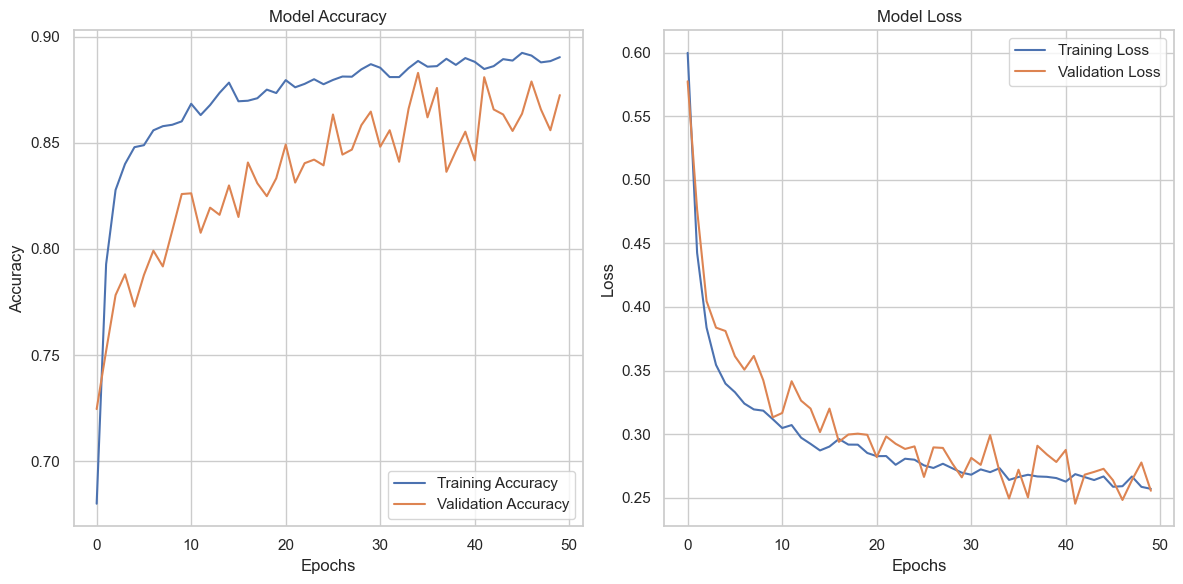

In [12]:
# Step 6: Neural Network Implementation


# Step 1: Resample the Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define the Model
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1851
           1       0.24      0.17      0.20       149

    accuracy                           0.90      2000
   macro avg       0.59      0.56      0.57      2000
weighted avg       0.88      0.90      0.89      2000


Confusion Matrix:
[[1767   84]
 [ 123   26]]


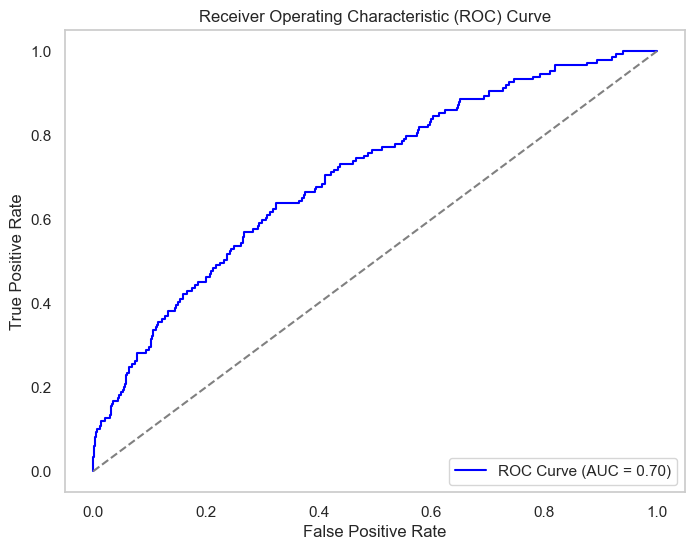

In [13]:
# Step 7: Model Evaluation on Test Data


# Generate Predictions
y_pred_proba = model.predict(X_test_scaled)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)    # Binary predictions

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


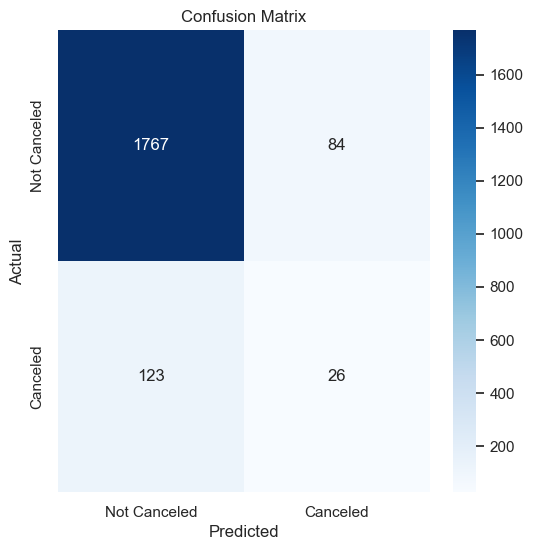

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1851
           1       0.24      0.17      0.20       149

    accuracy                           0.90      2000
   macro avg       0.59      0.56      0.57      2000
weighted avg       0.88      0.90      0.89      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


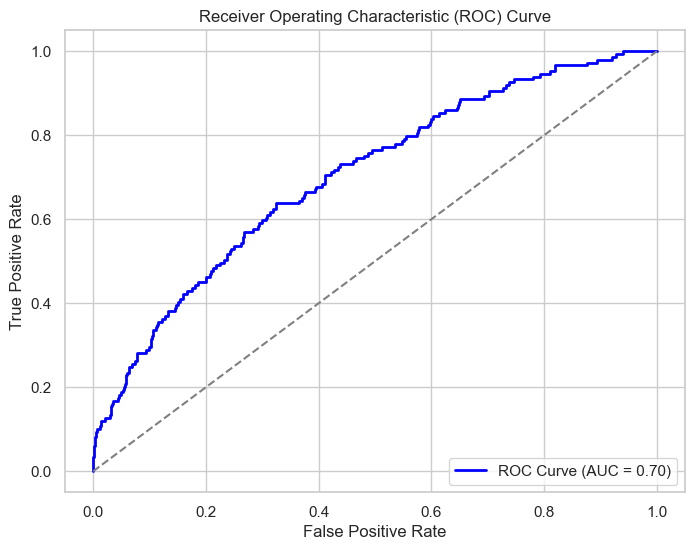

Accuracy: 0.8965


In [14]:
# Step 8: Model Evaluation

# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Additional Metrics (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

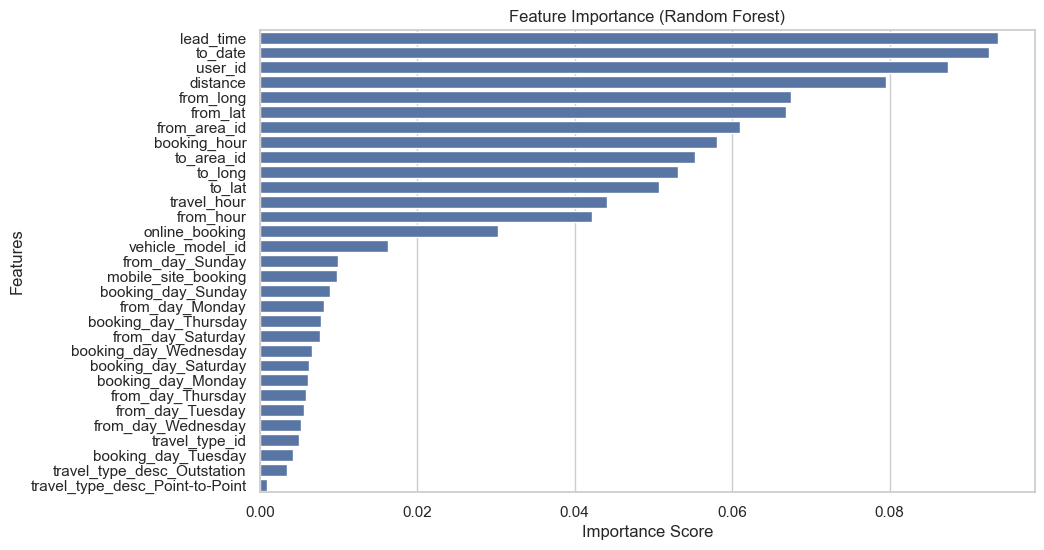

         Feature  Importance
15     lead_time    0.093772
5        to_date    0.092693
0        user_id    0.087362
16      distance    0.079575
9      from_long    0.067452
8       from_lat    0.066802
3   from_area_id    0.061038
12  booking_hour    0.058096
4     to_area_id    0.055311
11       to_long    0.053124


In [15]:
# Step 9: Feature Importance

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Print top 10 most important features
print(importances_df.head(10))
